# Passo 1. Configuração do projeto

In [1]:
import joblib
import os

import matplotlib 
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import seaborn as sns 

import sklearn 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC 
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB

print('Matplot version: {}'.format(matplotlib.__version__))
print('Numpy version  : {}'.format(np.__version__))
print('Pandas version : {}'.format(pd.__version__))
print('Sklearn version: {}'.format(sklearn.__version__))
print('Seaborn version: {}'.format(sns.__version__))


DATA_PATH = os.path.join('..', 'data', 'raw')
DATA_FILE = 'credit.csv'
DIABETES_DATA = os.path.join(DATA_PATH, DATA_FILE)

DEPLOY_PATH = os.path.join('..', 'model')
DEPLOY_FILE = 'finalized_model.sav'

RANDOM_STATE = 42

Matplot version: 3.3.2
Numpy version  : 1.19.2
Pandas version : 1.1.3
Sklearn version: 0.23.2
Seaborn version: 0.11.0


# Passo 2. Carga de dados

In [2]:
def load_data(data_path, data_file):
    csv_path = os.path.join(data_path, data_file)
    return pd.read_csv(csv_path)

credit_data = load_data(DATA_PATH, DATA_FILE)    

In [3]:
credit_data.columns=['Male','Age','Debt','Married','BankCustomer','EducationLevel','Ethnicity','YearsEmployed','PriorDefault','Employed','CreditScore','DriversLicense','Citizen','ZipCode','Income','Approved']

# Passo 3. Análise exploratória de dados

In [4]:
credit_data.head(5)

Male    Age   Debt Married BankCustomer EducationLevel Ethnicity  \
0    a  58.67  4.460       u            g              q         h   
1    a  24.50  0.500       u            g              q         h   
2    b  27.83  1.540       u            g              w         v   
3    b  20.17  5.625       u            g              w         v   
4    b  32.08  4.000       u            g              m         v   

   YearsEmployed PriorDefault Employed  CreditScore DriversLicense Citizen  \
0           3.04            t        t            6              f       g   
1           1.50            t        f            0              f       g   
2           3.75            t        t            5              t       g   
3           1.71            t        f            0              f       s   
4           2.50            t        f            0              t       g   

  ZipCode  Income Approved  
0   00043     560        +  
1   00280     824        +  
2   00100       3        +  
3   00120       0        +  
4   00360       0        +

In [5]:
print('Credit dataset tem {} linhas e {} colunas'.format(credit_data.shape[0], credit_data.shape[1]))

Credit dataset tem 689 linhas e 16 colunas


In [6]:
credit_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 689 entries, 0 to 688
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Male            689 non-null    object 
 1   Age             689 non-null    object 
 2   Debt            689 non-null    float64
 3   Married         689 non-null    object 
 4   BankCustomer    689 non-null    object 
 5   EducationLevel  689 non-null    object 
 6   Ethnicity       689 non-null    object 
 7   YearsEmployed   689 non-null    float64
 8   PriorDefault    689 non-null    object 
 9   Employed        689 non-null    object 
 10  CreditScore     689 non-null    int64  
 11  DriversLicense  689 non-null    object 
 12  Citizen         689 non-null    object 
 13  ZipCode         689 non-null    object 
 14  Income          689 non-null    int64  
 15  Approved        689 non-null    object 
dtypes: float64(2), int64(2), object(12)
memory usage: 86.2+ KB


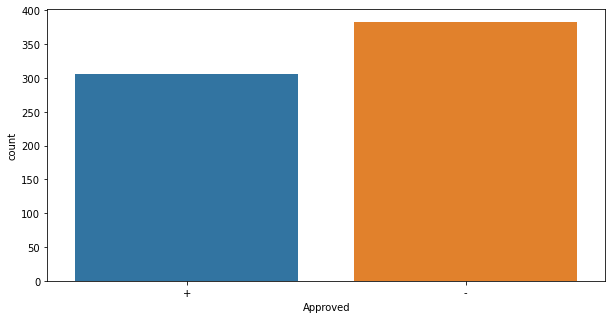

In [7]:
plt.figure(figsize=(10, 5))
_ = sns.countplot(x='Approved', data=credit_data)

## Verificando valores nulos (NA)

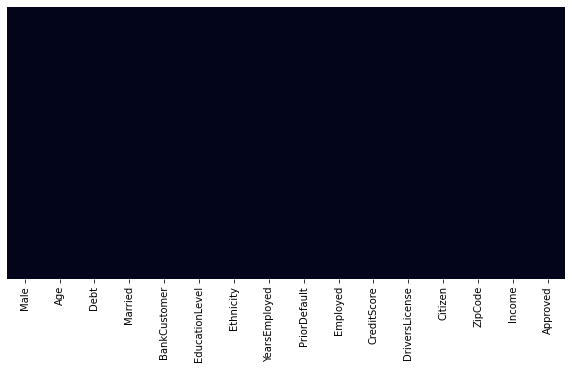

In [8]:
plt.figure(figsize=(10,5))
_ = sns.heatmap(credit_data.isnull(), yticklabels=False, cbar=False)

## Tranformacao de tipos de colunas do data frame

In [9]:
# Transformar dados do campo Approved: '+' em '1' e '-' em '0'
def define_approved(val):
    if val == '+':
        return '1'
    elif val == '-':
        return '0'   

In [10]:
credit_data['Approved'] = credit_data['Approved'].map(define_approved)

In [11]:
# Troca os '?' por NaN
credit_data = credit_data.replace('?', np.NaN)

In [12]:
credit_data["Approved"] = pd.to_numeric(credit_data["Approved"])
credit_data['Age'] = credit_data['Age'].astype('float')
credit_data['ZipCode'] = credit_data['ZipCode'].astype('float')

In [13]:
# seta os valores ausentes com a média 
credit_data.fillna(credit_data.mean(), inplace=True)

In [14]:
credit_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 689 entries, 0 to 688
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Male            677 non-null    object 
 1   Age             689 non-null    float64
 2   Debt            689 non-null    float64
 3   Married         683 non-null    object 
 4   BankCustomer    683 non-null    object 
 5   EducationLevel  680 non-null    object 
 6   Ethnicity       680 non-null    object 
 7   YearsEmployed   689 non-null    float64
 8   PriorDefault    689 non-null    object 
 9   Employed        689 non-null    object 
 10  CreditScore     689 non-null    int64  
 11  DriversLicense  689 non-null    object 
 12  Citizen         689 non-null    object 
 13  ZipCode         689 non-null    float64
 14  Income          689 non-null    int64  
 15  Approved        689 non-null    int64  
dtypes: float64(4), int64(3), object(9)
memory usage: 86.2+ KB


In [15]:
credit_data.head(5)

Male    Age   Debt Married BankCustomer EducationLevel Ethnicity  \
0    a  58.67  4.460       u            g              q         h   
1    a  24.50  0.500       u            g              q         h   
2    b  27.83  1.540       u            g              w         v   
3    b  20.17  5.625       u            g              w         v   
4    b  32.08  4.000       u            g              m         v   

   YearsEmployed PriorDefault Employed  CreditScore DriversLicense Citizen  \
0           3.04            t        t            6              f       g   
1           1.50            t        f            0              f       g   
2           3.75            t        t            5              t       g   
3           1.71            t        f            0              f       s   
4           2.50            t        f            0              t       g   

   ZipCode  Income  Approved  
0     43.0     560         1  
1    280.0     824         1  
2    100.0       3         1  
3    120.0       0         1  
4    360.0       0         1

## Correlação e distribuição dos dados

In [16]:
X = credit_data.drop(['Approved'], axis=1)
y = credit_data['Approved']

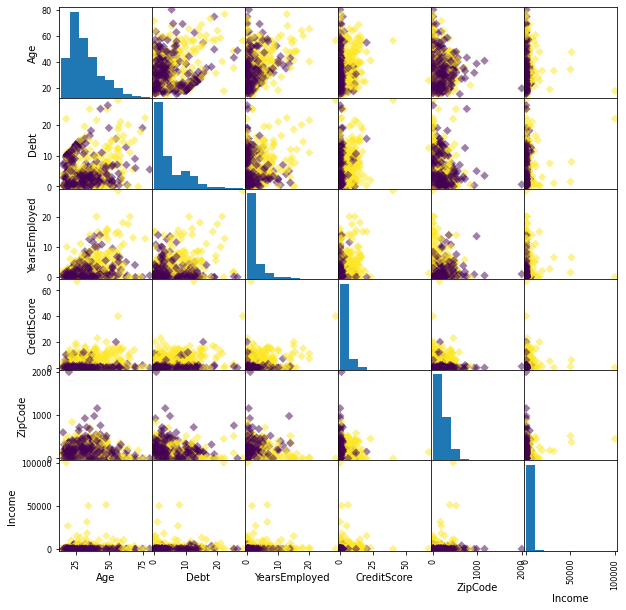

In [17]:
_ = pd.plotting.scatter_matrix(X, c=y, figsize=[10,10], marker='D')

# Passo 4. Preparacao dos dados

## 4.1 Amostragem aleatória

In [18]:
credit_amostra = credit_data.groupby('Approved', group_keys=False).apply( 
    lambda x: x.sample(min(len(x), 4), random_state=42) 
) 
credit_amostra = credit_data.reset_index(drop=True) 
credit_amostra

Male    Age    Debt Married BankCustomer EducationLevel Ethnicity  \
0      a  58.67   4.460       u            g              q         h   
1      a  24.50   0.500       u            g              q         h   
2      b  27.83   1.540       u            g              w         v   
3      b  20.17   5.625       u            g              w         v   
4      b  32.08   4.000       u            g              m         v   
..   ...    ...     ...     ...          ...            ...       ...   
684    b  21.08  10.085       y            p              e         h   
685    a  22.67   0.750       u            g              c         v   
686    a  25.25  13.500       y            p             ff        ff   
687    b  17.92   0.205       u            g             aa         v   
688    b  35.00   3.375       u            g              c         h   

     YearsEmployed PriorDefault Employed  CreditScore DriversLicense Citizen  \
0             3.04            t        t            6              f       g   
1             1.50            t        f            0              f       g   
2             3.75            t        t            5              t       g   
3             1.71            t        f            0              f       s   
4             2.50            t        f            0              t       g   
..             ...          ...      ...          ...            ...     ...   
684           1.25            f        f            0              f       g   
685           2.00            f        t            2              t       g   
686           2.00            f        t            1              t       g   
687           0.04            f        f            0              f       g   
688           8.29            f        f            0              t       g   

     ZipCode  Income  Approved  
0       43.0     560         1  
1      280.0     824         1  
2      100.0       3         1  
3      120.0       0         1  
4      360.0       0         1  
..       ...     ...       ...  
684    260.0       0         0  
685    200.0     394         0  
686    200.0       1         0  
687    280.0     750         0  
688      0.0       0         0  

[689 rows x 16 columns]

## 4.2 Tratamento de dados ausentes

### Identificacao de dados ausentes

In [19]:
credit_data.tail()

Male    Age    Debt Married BankCustomer EducationLevel Ethnicity  \
684    b  21.08  10.085       y            p              e         h   
685    a  22.67   0.750       u            g              c         v   
686    a  25.25  13.500       y            p             ff        ff   
687    b  17.92   0.205       u            g             aa         v   
688    b  35.00   3.375       u            g              c         h   

     YearsEmployed PriorDefault Employed  CreditScore DriversLicense Citizen  \
684           1.25            f        f            0              f       g   
685           2.00            f        t            2              t       g   
686           2.00            f        t            1              t       g   
687           0.04            f        f            0              f       g   
688           8.29            f        f            0              t       g   

     ZipCode  Income  Approved  
684    260.0       0         0  
685    200.0     394         0  
686    200.0       1         0  
687    280.0     750         0  
688      0.0       0         0

In [20]:
num_ausentes = (credit_data[['Male','Age','Debt','Married','BankCustomer','EducationLevel','Ethnicity','YearsEmployed','PriorDefault','Employed','CreditScore','DriversLicense','Citizen','ZipCode','Income','Approved']] == 0).sum()
print('Quantidade de dados ausentes:\n{}'.format(num_ausentes))

Quantidade de dados ausentes:
Male                0
Age                 0
Debt               18
Married             0
BankCustomer        0
EducationLevel      0
Ethnicity           0
YearsEmployed      70
PriorDefault        0
Employed            0
CreditScore       395
DriversLicense      0
Citizen             0
ZipCode           132
Income            294
Approved          383
dtype: int64


In [21]:
credit_data[['Debt','YearsEmployed','CreditScore','Citizen','ZipCode','Income','Approved']].replace(0, np.nan)
credit_data.isnull().sum()

Male              12
Age                0
Debt               0
Married            6
BankCustomer       6
EducationLevel     9
Ethnicity          9
YearsEmployed      0
PriorDefault       0
Employed           0
CreditScore        0
DriversLicense     0
Citizen            0
ZipCode            0
Income             0
Approved           0
dtype: int64

In [22]:
for c in range(credit_data.shape[1]):
    ausentes   = credit_data[[credit_data.columns[c]]].isnull().sum()
    percentual = ausentes / credit_data.shape[0] * 100
    print ("> %s, ausentes: %d (%.2f%%)" % (credit_data.columns[c], ausentes, percentual) )

> Male, ausentes: 12 (1.74%)
> Age, ausentes: 0 (0.00%)
> Debt, ausentes: 0 (0.00%)
> Married, ausentes: 6 (0.87%)
> BankCustomer, ausentes: 6 (0.87%)
> EducationLevel, ausentes: 9 (1.31%)
> Ethnicity, ausentes: 9 (1.31%)
> YearsEmployed, ausentes: 0 (0.00%)
> PriorDefault, ausentes: 0 (0.00%)
> Employed, ausentes: 0 (0.00%)
> CreditScore, ausentes: 0 (0.00%)
> DriversLicense, ausentes: 0 (0.00%)
> Citizen, ausentes: 0 (0.00%)
> ZipCode, ausentes: 0 (0.00%)
> Income, ausentes: 0 (0.00%)
> Approved, ausentes: 0 (0.00%)


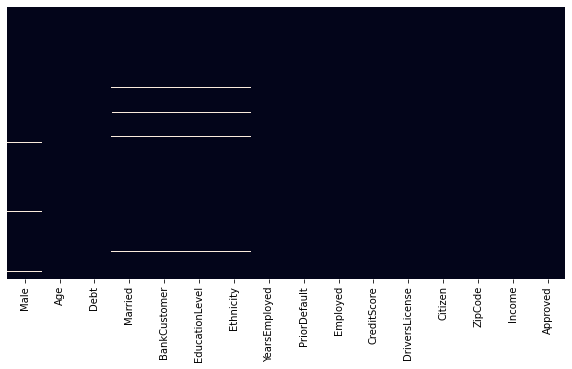

In [23]:
plt.figure(figsize=(10,5))
_ = sns.heatmap(credit_data.isnull(), yticklabels=False, cbar=False)

In [24]:
credit_data.describe()

Age        Debt  YearsEmployed  CreditScore      ZipCode  \
count  689.000000  689.000000     689.000000   689.000000   689.000000   
mean    31.569261    4.765631       2.224819     2.402032   183.988166   
std     11.861851    4.978470       3.348739     4.866180   172.282977   
min     13.750000    0.000000       0.000000     0.000000     0.000000   
25%     22.670000    1.000000       0.165000     0.000000    80.000000   
50%     28.580000    2.750000       1.000000     0.000000   160.000000   
75%     37.750000    7.250000       2.625000     3.000000   272.000000   
max     80.250000   28.000000      28.500000    67.000000  2000.000000   

              Income    Approved  
count     689.000000  689.000000  
mean     1018.862119    0.444122  
std      5213.743149    0.497229  
min         0.000000    0.000000  
25%         0.000000    0.000000  
50%         5.000000    0.000000  
75%       396.000000    1.000000  
max    100000.000000    1.000000

# Passo 5. Transformação de dados

In [25]:
credit_data.tail()

Male    Age    Debt Married BankCustomer EducationLevel Ethnicity  \
684    b  21.08  10.085       y            p              e         h   
685    a  22.67   0.750       u            g              c         v   
686    a  25.25  13.500       y            p             ff        ff   
687    b  17.92   0.205       u            g             aa         v   
688    b  35.00   3.375       u            g              c         h   

     YearsEmployed PriorDefault Employed  CreditScore DriversLicense Citizen  \
684           1.25            f        f            0              f       g   
685           2.00            f        t            2              t       g   
686           2.00            f        t            1              t       g   
687           0.04            f        f            0              f       g   
688           8.29            f        f            0              t       g   

     ZipCode  Income  Approved  
684    260.0       0         0  
685    200.0     394         0  
686    200.0       1         0  
687    280.0     750         0  
688      0.0       0         0

In [26]:
credit_data.drop(['Male'], axis=1, inplace=True)
credit_data.drop(['Married'], axis=1, inplace=True)
credit_data.drop(['BankCustomer'], axis=1, inplace=True)
credit_data.drop(['EducationLevel'], axis=1, inplace=True)
credit_data.drop(['Ethnicity'], axis=1, inplace=True)
credit_data.drop(['PriorDefault'], axis=1, inplace=True)
credit_data.drop(['Employed'], axis=1, inplace=True)
credit_data.drop(['DriversLicense'], axis=1, inplace=True)
credit_data.drop(['Citizen'], axis=1, inplace=True)

In [27]:
from sklearn.preprocessing import MinMaxScaler

X = credit_data.drop(['Approved'], axis=1)
y = credit_data['Approved']

scaler = MinMaxScaler() 
X_scaled = pd.DataFrame(scaler.fit_transform(X))
X_scaled.columns = X.columns

In [28]:
X_scaled.head()

Age      Debt  YearsEmployed  CreditScore  ZipCode   Income
0  0.675489  0.159286       0.106667     0.089552   0.0215  0.00560
1  0.161654  0.017857       0.052632     0.000000   0.1400  0.00824
2  0.211729  0.055000       0.131579     0.074627   0.0500  0.00003
3  0.096541  0.200893       0.060000     0.000000   0.0600  0.00000
4  0.275639  0.142857       0.087719     0.000000   0.1800  0.00000

# Passo 6. Particionamento do dataset

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, test_size=.3, random_state=RANDOM_STATE)

# Passo 7. Treinamento do modelo

In [30]:
def build_classifiers():
    classifiers=[]
    classifiers.append(
        ('knn',                                 # nome do classificador - Knn
         KNeighborsClassifier(),                #instancia do classificador
         {'n_neighbors':range(1,33,2)}          #hyperparametros
        )
    )
    classifiers.append(
        ('lr',                                  # nome do classificador - logistic regration
         LogisticRegression(max_iter=1000),     # instancia do classificador com 1000 interacoes
         {'penalty': ['l2'], 'C':[100, 10, 1, 0.1, 0.01]}  #hyperparametros
        )
    )
    classifiers.append(
        ('svm',                                 # nome do classificador - svm
         SVC(),                                 # instancia do classificador com 1000 interacoes
         { 'kernel': ['linear', 'rbf'],         # forma de analise         
           'C':[2**(-5), 1, 2**5, 2**10],       # custo 
           'gamma': [2**(-15),2**(-10),2**(-5), 1, 2**5]
          }  #hyperparametros
        )
    )
    classifiers.append(
        ('dt',                                  # nome do classificador - decision tree
         DecisionTreeClassifier(),              # instancia do classificador
         {'max_depth':[2,4,6,8,10,12]}          # hyperparametros
        )    
    )

    classifiers.append(
        ('rf',                                  # nome do classificador.
         RandomForestClassifier(),              # instancia do classificador.
         {'n_estimators': [10, 50, 100]}        # hyperparametros.
        )
    )
    
    classifiers.append(
        ('ada',                                 # nome do classificador - Ada Boost
         AdaBoostClassifier(base_estimator=DecisionTreeClassifier()),                  # instancia do classificador
         {'n_estimators': (1, 2),
          'base_estimator__max_depth': (1, 2),
          'algorithm': ('SAMME', 'SAMME.R')
          }         
        )                
    )   
    
    return classifiers
    

In [31]:
classifiers = build_classifiers()
results = []
names = []

for name, model, parameters in classifiers:
    print('\n>> classifier name: {}'.format(name) )
    gs = GridSearchCV(estimator = model, param_grid=parameters, refit=True, verbose = 1)
    kf = KFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)
    cv = cross_val_score(gs, X_train, y_train, cv=kf, scoring='accuracy')
    print('Mean:{}, Standard Defiation: {}'.format(cv.mean(), cv.std()))
    results.append(cv)
    names.append(name)


>> classifier name: knn
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
Fitting 5 folds for each of 16 candidates, tot

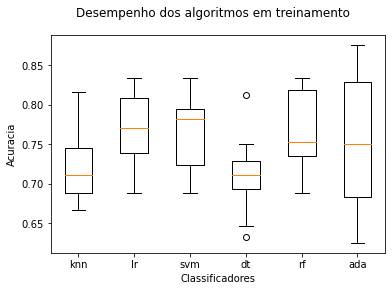

In [32]:
fig, ax = plt.subplots()
fig.suptitle('Desempenho dos algoritmos em treinamento')
plt.boxplot(results)
ax.set_xticklabels(names)
ax.set_ylabel('Acuracia')
ax.set_xlabel('Classificadores')
plt.show()

In [33]:
classifiers

[('knn', KNeighborsClassifier(), {'n_neighbors': range(1, 33, 2)}),
 ('lr',
  LogisticRegression(max_iter=1000),
  {'penalty': ['l2'], 'C': [100, 10, 1, 0.1, 0.01]}),
 ('svm',
  SVC(),
  {'kernel': ['linear', 'rbf'],
   'C': [0.03125, 1, 32, 1024],
   'gamma': [3.0517578125e-05, 0.0009765625, 0.03125, 1, 32]}),
 ('dt', DecisionTreeClassifier(), {'max_depth': [2, 4, 6, 8, 10, 12]}),
 ('rf', RandomForestClassifier(), {'n_estimators': [10, 50, 100]}),
 ('ada',
  AdaBoostClassifier(base_estimator=DecisionTreeClassifier()),
  {'n_estimators': (1, 2),
   'base_estimator__max_depth': (1, 2),
   'algorithm': ('SAMME', 'SAMME.R')})]

# Conclusao

#### Adicionado o classificador "AdaBoostClassifier"
#### Entre os algoritmos aplicados o que apresentou melhor acuracia foi o `SVM`